In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import math
from scipy.cluster.vq import kmeans, vq, whiten
from sklearn import metrics
from scipy.stats import multivariate_normal as mn
cluster = "cluster.txt"

In [2]:
x, y, pairs, cls = [], [], [], []
with open(cluster, 'r') as f:
    lines = f.readlines()
    for line in lines:
        if re.match('[1-9]\d*.\d*|0.\d*[1-9]\d*[1-9]\d*.\d*|0\.\d*[1-9]\d*[A-Z]\w+', line, flags = 0):
            data = line.split()
            x.append(float(data[0]))
            y.append(float(data[1]))
            pairs.append([float(data[0]), float(data[1])])
            if data[2] == 'Head':
                cls.append(1)
            elif data[2] == "Ear_left":
                cls.append(0)
            elif data[2] == "Ear_right":
                cls.append(2)         

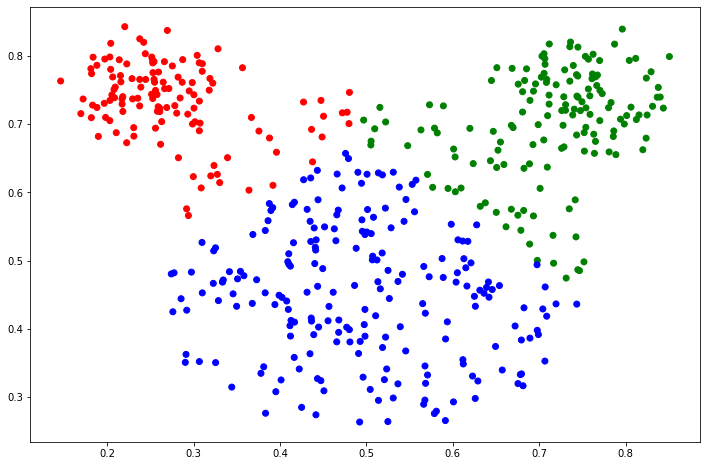

In [3]:
centroids,_ = kmeans(pairs,3)

centx = [centroids[i][0] for i in range(3)]
Z = zip(centroids, centx)
Z = sorted(Z, key = lambda x: x[1])
centroids, centx = zip(*Z)

km_res,_ = vq(pairs,centroids)
colors = ['red', 'blue', 'green']
col = []
for i in range(len(km_res)):
    col.append(colors[km_res[i]])
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(x, y, c = col)
plt.show()


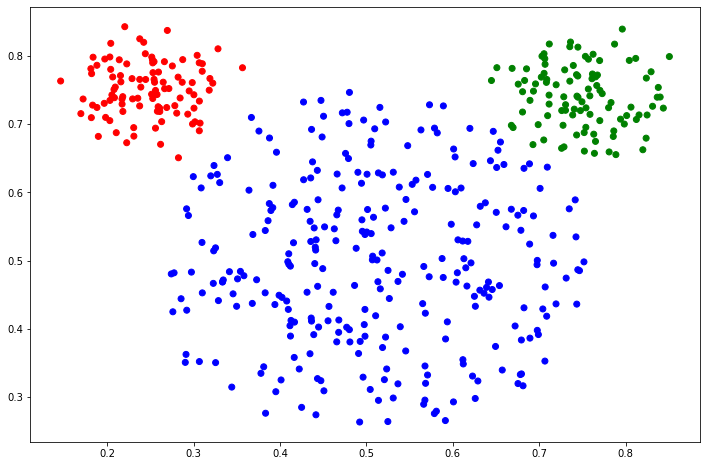

In [4]:
col2 = []
for i in range(len(cls)):
    if(cls[i] == 1):
        col2.append('blue')
    elif(cls[i] == 0):
        col2.append('red')
    elif(cls[i] == 2):
        col2.append('green')
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(x, y, c = col2)
plt.show()

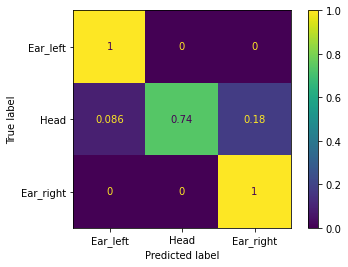

In [5]:
metrics.ConfusionMatrixDisplay.from_predictions(cls, km_res, normalize = 'true', display_labels = ['Ear_left', 'Head', 'Ear_right'])
plt.show()

In [6]:
#M-step
def update_mu(pairs, gamma, n_sample, n_class):
    mu = np.zeros((n_class,2))
    pairs = np.array(pairs)
    for i in range(n_class):
        top = 0
        bot = 0
        for j in range(n_sample):
            top += gamma[j][i] * pairs[j]
            bot += gamma[j][i]
        mu[i] = top / bot
    return mu

# def update_mu1(pairs, gamma, n_sample, n_class):
#     mu = np.zeros((n_class,2))
#     pairs = np.array(pairs)
#     for i in range(n_class):
#         mu[i] = np.average(pairs, axis = 0, weights = gamma[:, i])
#     return mu

def update_covar(pairs, gamma, mu, n_sample, n_class):
    covar = np.zeros((n_class,2))
    pairs = np.array(pairs)
    for i in range(n_class):
        top = 0
        bot = 0
        for j in range(n_sample):
            top += gamma[j][i] * ((pairs[i] - mu[i])**2)
            bot += gamma[j][i]
        covar[i] = top / bot
    return covar

def update_covar1(pairs, gamma, mu, n_sample, n_class):
    covar = np.zeros((n_class,2))
    for i in range(n_class):
        covar[i] = np.average((pairs - mu[i])**2, axis = 0,weights = gamma[:,i])
    return covar

def update_w(gamma):
    w = gamma.sum(axis = 0) / gamma.sum()
    return w


In [7]:
#E-step
def gaussian_pdf(pairs, mu, covar, num, cls, dim):
    f = np.exp(-(1/2) * np.transpose(pairs[num] - mu[cls]) * np.linalg.inv(cov) * (pairs[num] - mu[cls])) / (np.sqrt(np.linalg.det(covar)((2*math.pi)**dim)))
    return f

def update_gamma(pairs, mu, covar, w, n_sample, n_class):
    pdf = np.zeros((n_sample, n_class))
    for i in range(n_class):
        pdf[:,i] = w[i] * mn.pdf(pairs, mean = mu[i], cov = np.diag(covar[i]))
        gamma = pdf / pdf.sum(axis = 1).reshape(-1, 1)
    return gamma
    
def neg_log_like(paris, mu, covar, w, n_sample, n_class):
    pdf = np.zeros((n_sample, n_class))
    for i in range(n_class):
        pdf[:,i] = w[i] * mn.pdf(pairs, mean = mu[i], cov = np.diag(covar[i]))
    l = np.log(pdf.sum(axis = 1))
    return np.mean(l)

In [17]:
#Initialize
gamma = []
w = np.zeros(3)
for i in range(len(km_res)):
    if(km_res[i] == 0):
        temp = [1, 0, 0]
        w[0] += 1
        gamma.append(temp)
    if(km_res[i] == 1):
        temp = [0, 1, 0]
        w[1] += 1
        gamma.append(temp)
    if(km_res[i] == 2):
        temp = [0, 0, 1]
        w[2] += 1
        gamma.append(temp)
w = w / 490
gamma = np.array(gamma)

In [18]:
mu = update_mu(pairs, gamma, 490, 3)
covar = update_covar1(pairs, gamma, mu, 490, 3)
print(mu)
print(np.diag(covar[0]))

[[0.27459845 0.73311733]
 [0.49434079 0.45132857]
 [0.71207714 0.69805908]]
[[0.00543206 0.        ]
 [0.         0.00298001]]


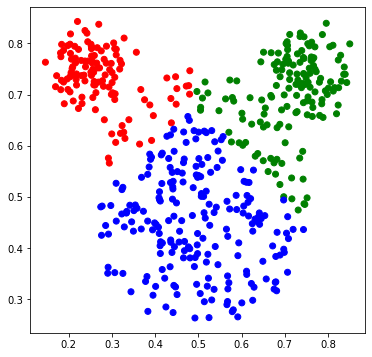

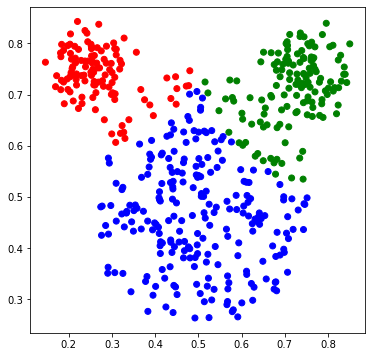

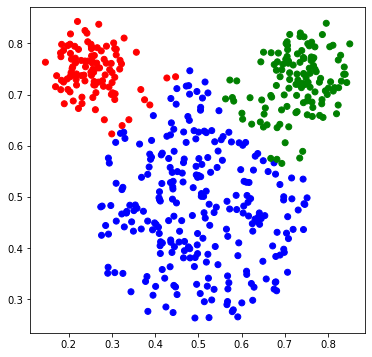

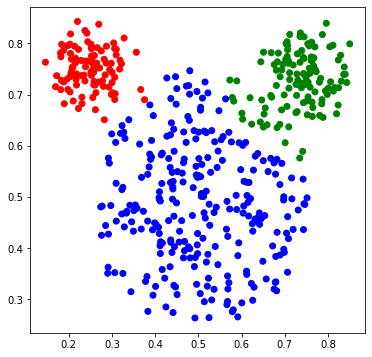

In [19]:
gmm_res = []
for i in range(490):
    gmm_res.append(np.argmax(gamma[i]))
col2 = []
for i in range(len(gmm_res)):
    col2.append(colors[gmm_res[i]])
fig, ax = plt.subplots(figsize = (6, 6))
plt.scatter(x, y, c = col2)
plt.show()
for n in range(3):
    gamma = update_gamma(pairs, mu, covar, w, 490, 3)
    w = update_w(gamma)
    mu = update_mu(pairs, gamma, 490, 3)
    covar = update_covar1(pairs, gamma, mu, 490, 3)
    gmm_res = []
    for i in range(490):
        gmm_res.append(np.argmax(gamma[i]))
    col2 = []
    for i in range(len(gmm_res)):
        col2.append(colors[gmm_res[i]])
    fig, ax = plt.subplots(figsize = (6, 6))
    plt.scatter(x, y, c = col2)
    plt.show()

In [20]:
prev_l = neg_log_like(pairs, mu, covar, w, 490, 3)
count = 4
while True:
    count += 1
    gamma = update_gamma(pairs, mu, covar, w, 490, 3)
    w = update_w(gamma)
    mu = update_mu(pairs, gamma, 490, 3)
    covar = update_covar1(pairs, gamma, mu, 490, 3)
    l = neg_log_like(pairs, mu, covar, w, 490, 3)
    if(abs(prev_l - l) < 10**-15):
        print("Iteration : ", count)
        break
    else:
        prev_l = l

Iteration :  30


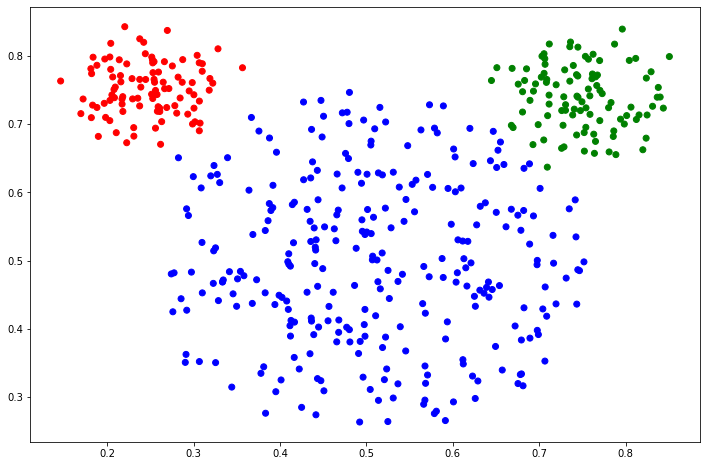

In [21]:
gmm_res = []
for i in range(490):
    gmm_res.append(np.argmax(gamma[i]))
col2 = []
for i in range(len(gmm_res)):
    col2.append(colors[gmm_res[i]])
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(x, y, c = col2)
plt.show()

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(cls, gmm_res, normalize = 'true', display_labels = ['Ear_left', 'Head', 'Ear_right'])
plt.show()